In [2]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from utils import greed_assignment,LAP
from plot_utils import plot_3d
from model import Siren,AssignmentModel,Autoencoder
from data_model import TravelTimeDataset,WaveSpeedDataset,get_latent
from sgld import SGLD
from ot.lp import wasserstein_1d
import matplotlib.pyplot as plt
import copy
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
grid_size=32 #In this notebook, we shortly use number of training wavespeed=1000, modes=10, grid_size=32, density=0.2 and L=4.  For larger size, more modes or higher accuracy, more training samples and multi-GPU are recommended.
vmin=0.5 # wave speed is scaled with unit as 10 km/s, the time is scaled with unit as 10 s and the spatial distance is scaled with unit 100 km.
vmax=2.5
n_station=20
n_wavespeed=1000
n_wavespeed_test=10
n_mode=10
density=0.2

## Generate wave speed dataset

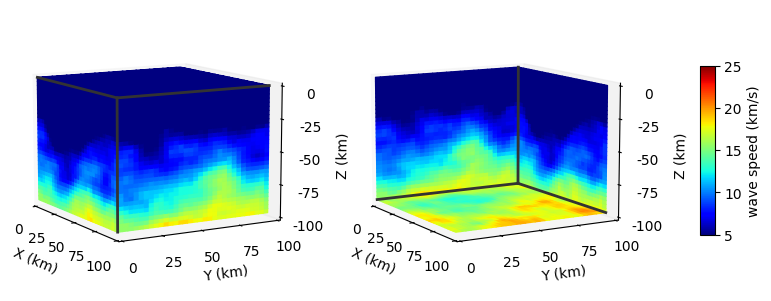

In [4]:
WaveSpeedData=WaveSpeedDataset(n_wavespeed,n_wavespeed_test, grid_size,n_mode,density,vmin,vmax)
torch.save(WaveSpeedData,'save/WaveSpeedData.pt') 
#WaveSpeedData=torch.load('save/WaveSpeedData.pt')
_=plot_3d(WaveSpeedData.data_wavespeed[0],vmin=vmin*10,vmax=vmax*10)


# Train autoencoder

In [6]:
L=4 #latent dim
model_autoencoder=Autoencoder(capacity=128,latent_dims=L).to(device)
ATE_train_loader = torch.utils.data.DataLoader(WaveSpeedData, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(params=model_autoencoder.parameters(), lr=1e-3)
#model_autoencoder.load_state_dict(torch.load('save/model_autoencoder.pt'))

<All keys matched successfully>

In [5]:
model_autoencoder.train()
train_loss_avg = []
num_epochs=1000000
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    #for data in tqdm(ATE_train_loader):
    for data in ATE_train_loader:
        image_batch = data['image'].to(device)
        image_batch=image_batch.unsqueeze(1)
        image_batch_recon,_ = model_autoencoder(image_batch)
        loss = F.mse_loss(image_batch_recon, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    if train_loss_avg[-1]<5e-3:
        break
    if epoch%10==0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
        torch.save(model_autoencoder.state_dict(), 'save/model_autoencoder.pt')


Training ...
Epoch [1 / 1000000] average reconstruction error: 0.813380
Epoch [11 / 1000000] average reconstruction error: 0.048932
Epoch [21 / 1000000] average reconstruction error: 0.026002
Epoch [31 / 1000000] average reconstruction error: 0.024505
Epoch [41 / 1000000] average reconstruction error: 0.021069
Epoch [51 / 1000000] average reconstruction error: 0.018369
Epoch [61 / 1000000] average reconstruction error: 0.018536
Epoch [71 / 1000000] average reconstruction error: 0.013263
Epoch [81 / 1000000] average reconstruction error: 0.016459
Epoch [91 / 1000000] average reconstruction error: 0.010986
Epoch [101 / 1000000] average reconstruction error: 0.011271
Epoch [111 / 1000000] average reconstruction error: 0.010306
Epoch [121 / 1000000] average reconstruction error: 0.011824
Epoch [131 / 1000000] average reconstruction error: 0.014123
Epoch [141 / 1000000] average reconstruction error: 0.012645
Epoch [151 / 1000000] average reconstruction error: 0.011414
Epoch [161 / 1000000] 

Error 0.036200106


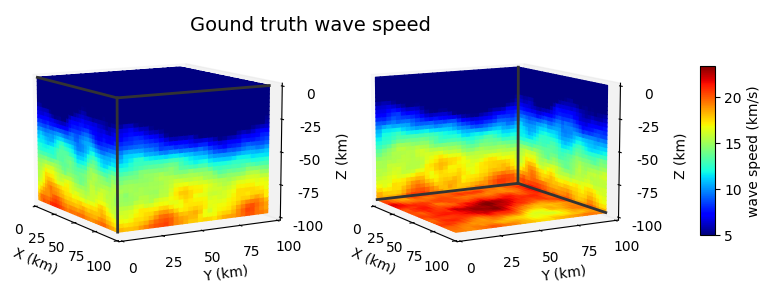

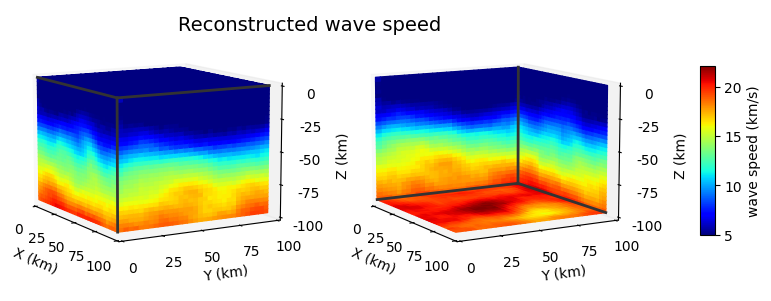

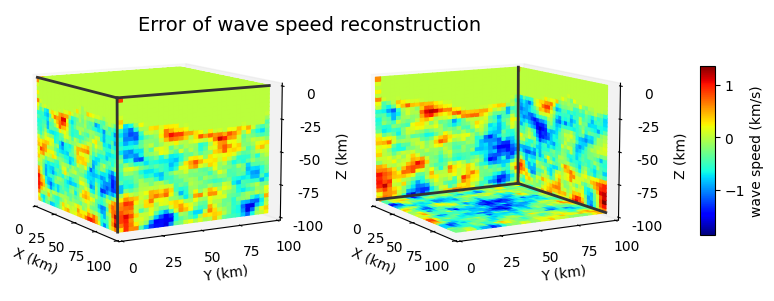

In [7]:
#visualize generalization -- test wave speed reconstruction
model_autoencoder.eval()
id=1 # index of wave speed to plot
real_c=WaveSpeedData.data_wavespeed_test[id]

figlist=plot_3d(real_c)
figlist[0].suptitle("Gound truth wave speed", fontsize=14,y=0.72)
data_input=torch.tensor(WaveSpeedData.data_wavespeed_test[id]).unsqueeze(0).unsqueeze(0).float().to(device)
re_c=model_autoencoder(data_input)[0].squeeze().clone().detach().cpu().numpy()
figlist=plot_3d(re_c)
figlist[0].suptitle("Reconstructed wave speed", fontsize=14,y=0.72)
figlist=plot_3d(re_c-real_c)
figlist[0].suptitle("Error of wave speed reconstruction", fontsize=14,y=0.72)
print('Error', np.sqrt(((re_c-real_c)**2).mean()))

# Train neural fields model

In [8]:
L=4
scaler=get_latent(WaveSpeedData,model_autoencoder,device) # scale z into [-1,1]
z_matrix_scale=scaler.scale_z(scaler.z_matrix)
z_matrix_test_scale=scaler.scale_z(scaler.z_matrix_test)
ttdata=TravelTimeDataset(WaveSpeedData,z_matrix_scale,z_matrix_test_scale,n_station,grid_size)
#torch.save(ttdata,'save/ttdata.pt',pickle_protocol=5)

100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


In [9]:
batch_size_siren=20000
first_omega_0=15
hidden_omega_0=15
model_traveltime= Siren(in_features=3+L, out_features=n_station, hidden_features=512, 
                        hidden_layers=4, outermost_linear=True,first_omega_0=first_omega_0, hidden_omega_0=hidden_omega_0).to(device)
optimizer = torch.optim.Adam(model_traveltime.parameters(), lr=0.00001)
loss_function=torch.nn.MSELoss(reduction='mean')
train_loader = torch.utils.data.DataLoader(ttdata, batch_size=batch_size_siren, shuffle=True,num_workers=20)

In [10]:
for epoch in range(50):
    model_traveltime.train()
    loss_batch = 0
    for data in tqdm(train_loader):
        X = data['in'].float().to(device)
        Y = data['out'].float().to(device)
        Ypred,_= model_traveltime(X)
        loss = loss_function(Y, Ypred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch += loss.item()

    if epoch%1==0:
        loss_epoch = loss_batch/len(train_loader)
        print(f'Epoch: {epoch:03d}, Train Loss: {loss_epoch:.2E}')
        torch.save(model_traveltime.state_dict(), 'save/model_traveltime.pt')
    if loss_epoch<1e-4:
        break

100%|██████████| 1639/1639 [00:53<00:00, 30.47it/s]


Epoch: 000, Train Loss: 3.46E-02


100%|██████████| 1639/1639 [00:53<00:00, 30.67it/s]


Epoch: 001, Train Loss: 1.72E-03


100%|██████████| 1639/1639 [00:54<00:00, 30.29it/s]


Epoch: 002, Train Loss: 9.60E-04


100%|██████████| 1639/1639 [00:52<00:00, 30.94it/s]


Epoch: 003, Train Loss: 7.07E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.27it/s]


Epoch: 004, Train Loss: 5.60E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.05it/s]


Epoch: 005, Train Loss: 4.59E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.09it/s]


Epoch: 006, Train Loss: 3.88E-04


100%|██████████| 1639/1639 [00:52<00:00, 30.96it/s]


Epoch: 007, Train Loss: 3.36E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.49it/s]


Epoch: 008, Train Loss: 2.97E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.34it/s]


Epoch: 009, Train Loss: 2.68E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.57it/s]


Epoch: 010, Train Loss: 2.44E-04


100%|██████████| 1639/1639 [00:54<00:00, 29.88it/s]


Epoch: 011, Train Loss: 2.26E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.08it/s]


Epoch: 012, Train Loss: 2.10E-04


100%|██████████| 1639/1639 [00:52<00:00, 30.94it/s]


Epoch: 013, Train Loss: 1.98E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.42it/s]


Epoch: 014, Train Loss: 1.87E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.40it/s]


Epoch: 015, Train Loss: 1.78E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.57it/s]


Epoch: 016, Train Loss: 1.70E-04


100%|██████████| 1639/1639 [00:55<00:00, 29.75it/s]


Epoch: 017, Train Loss: 1.62E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.32it/s]


Epoch: 018, Train Loss: 1.56E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.09it/s]


Epoch: 019, Train Loss: 1.51E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.05it/s]


Epoch: 020, Train Loss: 1.46E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.40it/s]


Epoch: 021, Train Loss: 1.41E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.50it/s]


Epoch: 022, Train Loss: 1.37E-04


100%|██████████| 1639/1639 [00:54<00:00, 29.88it/s]


Epoch: 023, Train Loss: 1.33E-04


100%|██████████| 1639/1639 [00:54<00:00, 29.94it/s]


Epoch: 024, Train Loss: 1.29E-04


100%|██████████| 1639/1639 [00:54<00:00, 30.32it/s]


Epoch: 025, Train Loss: 1.26E-04


100%|██████████| 1639/1639 [00:54<00:00, 29.84it/s]


Epoch: 026, Train Loss: 1.23E-04


100%|██████████| 1639/1639 [00:53<00:00, 30.89it/s]


Epoch: 027, Train Loss: 1.20E-04


  1%|          | 12/1639 [00:05<12:13,  2.22it/s] 


KeyboardInterrupt: 

## Generate phase association dataset

In [11]:
test_id=1
n_earthquake=8
tau_max_dataset=0.1# The time is scaled with unit as 10 s, so 1=10s
loc_earthquake_index=np.random.randint(grid_size,size=[n_earthquake,3])
tt=ttdata.data_test[test_id].reshape(n_station,grid_size,grid_size,grid_size)
true_receiver= tt[:,loc_earthquake_index[:,0],loc_earthquake_index[:,1],loc_earthquake_index[:,2]]
loc_earthquake_coord=loc_earthquake_index/(grid_size-1)
time_earthquake = np.random.rand(n_earthquake)*tau_max_dataset

## received signal is sorted
true_station_travelingtime=np.zeros_like(true_receiver)
true_station_travelingtime_index=np.zeros_like(true_receiver,dtype=int)
for i in range(n_station):
    true_receiver[i,:]=true_receiver[i,:]+time_earthquake
    true_station_travelingtime[i,:]=np.sort(true_receiver[i,:])
    true_station_travelingtime_index[i,:]=np.argsort(true_receiver[i,:])

import scipy.stats as stats
sum_tau=0
for i in range(n_station):
    tau, p_value = stats.kendalltau(time_earthquake, true_receiver[i,:])
    sum_tau+=tau
CF=1-max(sum_tau/n_station,0)
print('Confusion factor:',CF)    
z_truth=ttdata.output_test(test_id)['z']

Confusion factor: 1


## Run!

In [12]:
for try_i in range(5): # usually need 1~5 trials 
    loc_record_list=[]
    lowest_loss=100000
    L=4 #dimention of the wave speed, for fixed wave speed, L=0
    batch_size=100
    model_traveltime_=copy.deepcopy(model_traveltime).to(device)
    tau_max=np.min(np.max(true_station_travelingtime,axis=1))-0.5 #estimate tau_max
    print(tau_max)
    AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L).to(device)
    #AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L,cheat=True,loc_earthquake_truth=loc_earthquake_coord,time_earthquake_truth=time_earthquake,z_truth=z_truth).to(device)
    # In cheat mode, the parameters will be initialized around the grount truth.  This is used to check whether the SIREN and auto-encoder are well trained.
    #optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
    
    for epoch in range(50):
        loss_batch = 0
        count=0
        for count in range(batch_size):
            i=np.random.randint(n_station) ## update one station at each time 
            out=AModel().T
            outi=out[i,:]
            Y=torch.tensor(true_station_travelingtime[i,:]).float().to(device)
            loss = wasserstein_1d(outi, Y, p=2)
            loss_batch += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch = loss_batch/batch_size
        
        
        
        # if epoch<60:
        #     if epoch%3==0:
        #         optimizer = SGLD([{'params': AModel.time_earthquake,'lr': 0.01, 'noise':1e-3}])
        #     if epoch%3==1:
        #         optimizer = SGLD([{'params': AModel.loc_earthquake,'lr': 0.01, 'noise':1e-3}])
        #     if epoch%3==2:
        #         optimizer = SGLD([{'params': AModel.z,'lr': 0.01, 'noise':1e-3}])
        # else:
        #     if epoch==60:
        #         optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
        # val test
        loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
        loc_record_list.append(loc_earthquake_re)
        indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
        loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
        time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
        time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
        z=AModel.z.detach().clone().cpu().numpy()
        z_error=np.mean((z-z_truth)**2)
        if loss_epoch <lowest_loss:
            lowest_loss= loss_epoch
            lowest_loss_loc_earthquake_re = loc_earthquake_re
            lowest_loss_time_earthquake_re = time_earthquake_re
            lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
        
        print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}, Z error: {z_error:.6f}')    
    if loss_epoch<0.001:
        break
    


optimizer = SGLD(AModel.parameters(), lr=0.001,noise=1e-4)
for epoch in range(100):
    loss_batch = 0
    count=0
    for count in range(batch_size):
        i=np.random.randint(n_station) ## update one station at each time 
        out=AModel().T
        outi=out[i,:]
        Y=torch.tensor(true_station_travelingtime[i,:]).float().to(device)
        loss = wasserstein_1d(outi, Y, p=2)
        loss_batch += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch = loss_batch/batch_size
    
    ## val test
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
    loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
    time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
    time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
    z=AModel.z.detach().clone().cpu().numpy()
    z_error=np.mean((z-z_truth)**2)
    if loss_epoch <lowest_loss:
        lowest_loss= loss_epoch
        lowest_loss_loc_earthquake_re = loc_earthquake_re
        lowest_loss_time_earthquake_re = time_earthquake_re
        lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
    print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}, Z error: {z_error:.6f}')


0.7138671875


/scicore/home/dokman0000/shi0000/anaconda3/envs/newtorch/lib/python3.10/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  cws = cws.T.contiguous()
/scicore/home/dokman0000/shi0000/GNNSEI/public_version/sgld.py:52: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  square_avg.mul_(alpha).addcmul_(1-alpha, d_p

Try: 000,Epoch: 000, Loss: 0.012421, Loc error: 0.012798, Time error: 0.016190, Z error: 0.029767


Try: 000,Epoch: 001, Loss: 0.003906, Loc error: 0.008681, Time error: 0.007636, Z error: 0.010807
Try: 000,Epoch: 002, Loss: 0.001779, Loc error: 0.006289, Time error: 0.005045, Z error: 0.004926
Try: 000,Epoch: 003, Loss: 0.001072, Loc error: 0.002304, Time error: 0.005964, Z error: 0.001450
Try: 000,Epoch: 004, Loss: 0.001464, Loc error: 0.001009, Time error: 0.002889, Z error: 0.001581
Try: 000,Epoch: 005, Loss: 0.001090, Loc error: 0.000534, Time error: 0.002365, Z error: 0.001314
Try: 000,Epoch: 006, Loss: 0.001201, Loc error: 0.001238, Time error: 0.001099, Z error: 0.001361
Try: 000,Epoch: 007, Loss: 0.000986, Loc error: 0.000421, Time error: 0.000324, Z error: 0.000140
Try: 000,Epoch: 008, Loss: 0.000950, Loc error: 0.000522, Time error: 0.000423, Z error: 0.000194
Try: 000,Epoch: 009, Loss: 0.000661, Loc error: 0.000794, Time error: 0.000642, Z error: 0.000112
Try: 000,Epoch: 010, Loss: 0.000961, Loc error: 0.000386, Time error: 0.000421, Z error: 0.000151
Try: 000,Epoch: 011,

Accuracy: 0.9375


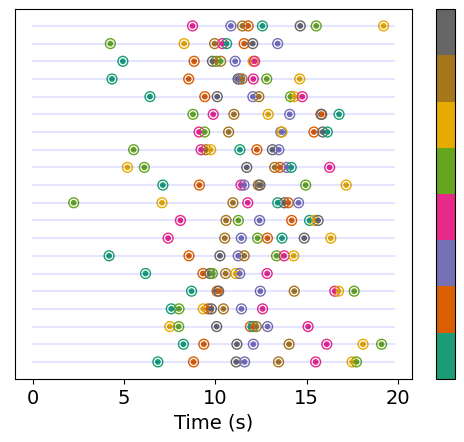

In [13]:
assignment_function=LAP
plt.rcParams.update({'font.size': 14})
indexB=assignment_function(loc_earthquake_coord,loc_earthquake_re)  #to get a order
plt.figure(figsize=(6.4, 4.8))
Crange=range(n_earthquake)
xaxis_max=lowest_loss_out.max()*1.1
cmap = plt.cm.get_cmap('Dark2', n_earthquake)
correct_rate=0
for i in range(n_station):
    yaxis_i=np.ones(n_earthquake)*i
    tx=true_station_travelingtime[i,]
    ti=true_station_travelingtime_index[i,:]
    out=lowest_loss_out[i,:]
    indexBi=assignment_function(out.reshape(-1,1),tx.reshape(-1,1))
    plt.plot([0,xaxis_max*9.5],[i,i],'-b',alpha=0.1)
    plt.scatter(tx*10,yaxis_i,marker='o', facecolors='none',s=50,alpha=1,edgecolors=cmap(ti[Crange]))
    plt.scatter(tx*10,yaxis_i,cmap=cmap,c=indexB[indexBi[Crange]],s=10,alpha=1)
    correct_rate+=np.mean(ti[Crange]==indexB[indexBi[Crange]])
cbar=plt.colorbar()
plt.xlabel('Time (s)')
plt.yticks([])
cbar.ax.tick_params(length=0)
cbar.set_ticks([])
print('Accuracy:',correct_rate/n_station)

Text(0.5, 0.72, 'Error of reconstructed wave speed')

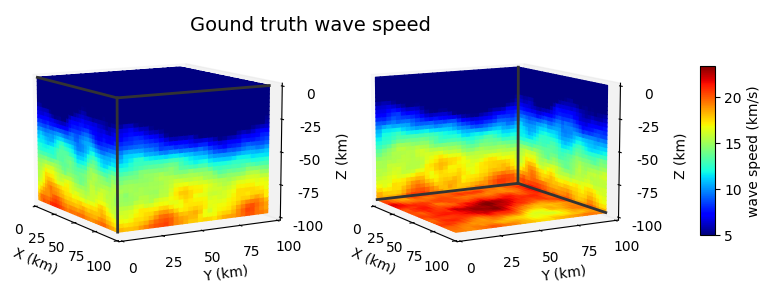

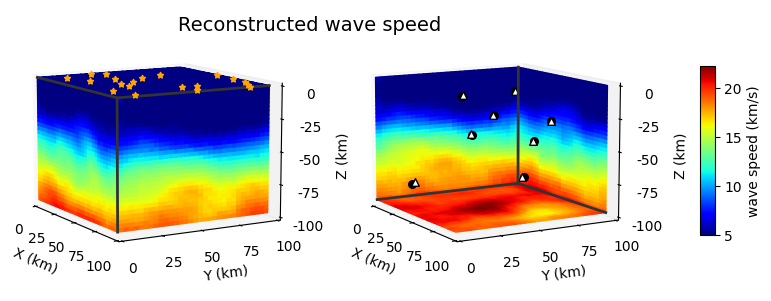

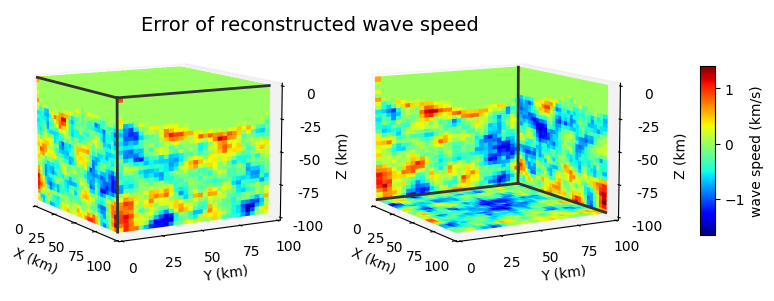

In [14]:

plt.rcParams.update({'font.size': 10})
z0=AModel.z.detach().clone().cpu().numpy()
z_re=scaler.scale_z_inv(z0)
z_re=torch.tensor(z_re).float().to(device)

V_re=model_autoencoder.decoder(z_re.reshape(1,-1)).detach().clone().cpu().numpy()[0][0]
# plot ground truth wave speed 
figlist=plot_3d(real_c)
figlist[0].suptitle("Gound truth wave speed", fontsize=14,y=0.72)
# plot wave speed reconstrcuction
figlist=plot_3d(V_re)
figlist[0].suptitle("Reconstructed wave speed", fontsize=14,y=0.72)
ax0=figlist[1]
ax1=figlist[2]

#plt.subplots_adjust(wspace=0)
loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
loc_earthquake=loc_earthquake_coord
cp=plt.cm.get_cmap('Accent', n_earthquake)


ax1.scatter(loc_earthquake_re[:,0]*(grid_size-1),loc_earthquake_re[:,1]*(grid_size-1),-loc_earthquake_re[:,2]*(grid_size-1),s=30,color='black',marker='o',label='Earthquake',depthshade=0,edgecolors='black')
ax1.scatter(loc_earthquake[:,0]*(grid_size-1),loc_earthquake[:,1]*(grid_size-1),-loc_earthquake[:,2]*(grid_size-1),s=30,color='white',marker='^',label='Earthquake',depthshade=0,edgecolors='black')
coord=ttdata.loc_station_coord*grid_size
ax0.scatter3D(coord[:,0],coord[:,1],coord[:,2],s=20,depthshade=0,zorder=1e20,marker=(5, 1),color='orange')
# plot diff
figlist=plot_3d(V_re-real_c)
figlist[0].suptitle("Error of reconstructed wave speed", fontsize=14,y=0.72)

In [15]:
min_min_list=lowest_loss
assignment_function=LAP
indexB=assignment_function(loc_earthquake_coord,loc_earthquake_re)  #to get a order
Crange=range(n_earthquake)
correct_rate=0
dloss=0
for i in range(n_station):
    yaxis_i=np.ones(n_earthquake)*i
    tx=true_station_travelingtime[i,]
    ti=true_station_travelingtime_index[i,:]
    out=lowest_loss_out[i,:]
    indexBi=assignment_function(out.reshape(-1,1),tx.reshape(-1,1))
    dloss = dloss+np.sum((tx-out[indexBi])**2)
    correct_rate+=np.mean(ti[Crange]==indexB[indexBi[Crange]])
Accuracy=correct_rate/n_station
dloss=np.sqrt(dloss/n_station/n_earthquake)
print('Earthquake spatial locations:', np.sqrt(loc_error*3)*100,'km')
print('Accuracy:',Accuracy)
print('Wave speed reconstruction error:',np.sqrt(np.mean((V_re-real_c)**2))*10,'km/s')

Earthquake spatial locations: 1.9048850004719609 km
Accuracy: 0.9375
Wave speed reconstruction error: 0.34101296216249466 km/s
